# Neural Networks

## Introduction

In this exercise you will implement the neural network of Fig. 5.4 in several
steps. In each step you will train the model on an image-segmentation pair that
is provided, and use it to segment an unseen scan. You will also be asked to
critically analyze the behavior of the model in different scenarios.

The data for this exercise consists of the files dataForNN inside clip0.mat,
dataForNN foreBorder clip0.mat and dataForNN foreBorder clip1.mat. In
each file you will find the images trainingImage and trainingSegmentation,
which you should use to train your models, and another image testImage that
you should automatically segment with the trained models. The pixels belonging to the foreground vs. background in the segmentations have values 1 and 0,
respectively.

For each of the tasks below, you should implement models with M = 6 basis functions $\phi_m(x)$, and optimize the model parameters $\theta$ on the training data using stochastic gradient descent (Eq. (4.8)). Reasonable settings for the optimization are $N' = 200$ and $ν' = 0.005$, and you should run the algorithm for a sufficiently large number of iterations, e.g., $5000$. It is good practice to plot the evolution of the cross-entropy (Eq. (4.7)) across iterations, as this will allow you to fine-tune $N'$ and $ν'$ if needed. Since you will draw $N'$ new samples in each iteration, the evolution of the cross-entropy will be noisy – however the overall trend should be that it decreases as the iterations progress (and stabilizes before the training is ended). It is also recommended to visualize the output of the classifier on the training and/or test image during training, as in Fig. 4.2(b).

### Instructions for your report
Your report should be structured as follows:
* **Introduction**: a short summary of what your report is about, perhaps with a recap of some of the equations you'll be using in your solution.
* **Task 1, ..., 5**: for each specific task listed below, your code (in code cells), your results (as figures) as well as explanations of what is computed and what is shown in the figures (in Markdown cells). 
* **Conclusion**: a short summary of your findings.

This introduction should **not** be part of your report.

### Input data and code hints
Import Python libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

<font size="5">Initialization</font>

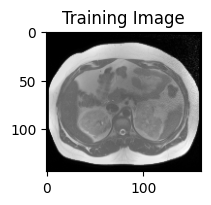

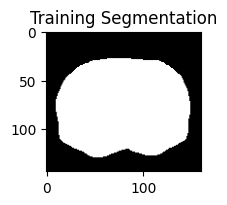

In [2]:
M = 6
noOfSamples = 200
vm = 0.005
numIter = 5000

# Load data
clip0 = np.load('dataForNN_inside_clip0.npy', allow_pickle=True).tolist()

TI = clip0['trainingImage']
TS = clip0['trainingSegmentation']
TestI = clip0['testImage']
TestS = clip0['testSegmentation']

# Show image
plt.figure(figsize=(2,2))
plt.imshow(clip0['trainingImage'], cmap='gray')
plt.title('Training Image')
plt.show()

plt.figure(figsize=(2,2))
plt.imshow(clip0['trainingSegmentation'], cmap='gray')
plt.title('Training Segmentation')
plt.show()

## Task 1: Pixel-wise logistic regression classifier

For the data file ```dataForNN_inside_clip0.mat``` implement a pixel-wise logistic regression classifier $p(l \vert d, \theta)$, using fixed basis functions of the form

$$ \phi_m (d) = \cos[\pi(m-1)d] $$

You can use $\hat{w}_m = 0, \forall m$ for initializing the stochastic gradient descent algorithm.

Include in your report:
- a plot of the evolution of the cross-entropy across iterations
- the final segmentation of the test image
- the quantity $a$ and the obtained classifier (as in figure ...)
- visualization of where training samples are located (e.g. show $N^{\prime}$ samples of the last iteration of the stochastic gradient descent algorithm)

> ***Hints:***
> - getInputFeatures() provides images patches as input features based on ```numberOfNeighbors```
> - getSamples() collects sample data
> - showLocationOfSamples() plots the collected sample data
> - def plotSeg() overlays a segmentation on top of an image
>
> - for the sake of simplicity, you should compute the gradient $\nabla E_{N^{\prime}}(\theta)$ using the method of infinite differences. E.g. 
>       
>       gradient[n] = (newCost - cost[i]) / delta
>
>   computes the gradient for the $i^{th}$ iteration for the $n^{th}$ theta parameter 


The following functions are provided:

    getInputFeatures(), getSamples(), showLocationOfSamples(), plotSeg()

In [ ]:
def getInputFeatures(image, numberOfNeighbors, shift=1):
    numberOfFeatures = numberOfNeighbors + 1

    leftNeighborImage = np.zeros_like(image)
    leftNeighborImage[:, shift:] = image[:, :-shift]

    rightNeighborImage = np.zeros_like(image)
    rightNeighborImage[:, :-shift] = image[:, shift:]

    topNeighborImage = np.zeros_like(image)
    topNeighborImage[shift:, :] = image[:-shift, :]

    bottomNeighborImage = np.zeros_like(image)
    bottomNeighborImage[:-shift, :] = image[shift:, :]

    leftTopNeighborImage = np.zeros_like(image)
    leftTopNeighborImage[shift:, shift:] = image[:-shift, :-shift]

    rightTopNeighborImage = np.zeros_like(image)
    rightTopNeighborImage[shift:, :-shift] = image[:-shift, shift:]

    leftBottomNeighborImage = np.zeros_like(image)
    leftBottomNeighborImage[:-shift, shift:] = image[shift:, :-shift]

    rightBottomNeighborImage = np.zeros_like(image)
    rightBottomNeighborImage[:-shift, :-shift] = image[shift:, shift:]

    if numberOfNeighbors == 0:
        features = image.ravel()
    elif numberOfNeighbors == 1:
        features = np.column_stack((image.ravel(), bottomNeighborImage.ravel()))
    elif numberOfNeighbors == 4:
        features = np.column_stack((
            image.ravel(),
            leftNeighborImage.ravel(),
            rightNeighborImage.ravel(),
            topNeighborImage.ravel(),
            bottomNeighborImage.ravel()
        ))
    elif numberOfNeighbors == 8:
        features = np.column_stack((
            image.ravel(),
            leftTopNeighborImage.ravel(),
            topNeighborImage.ravel(),
            rightTopNeighborImage.ravel(),
            leftNeighborImage.ravel(),
            rightNeighborImage.ravel(),
            leftBottomNeighborImage.ravel(),
            bottomNeighborImage.ravel(),
            rightBottomNeighborImage.ravel()
        ))
    else:
        raise NotImplementedError("Number of neighbors not implemented yet")

    featureImage = features.reshape((image.shape[0], image.shape[1], numberOfFeatures))
    return featureImage

def getSamples(featureImage, segmentation, numberOfSamples, mask=None):
    if mask is None:
        mask = np.ones(segmentation.shape)

    numberOfFeatures = featureImage.shape[2]
    numberOfPixels = featureImage.shape[0] * featureImage.shape[1]

    numberOfSamplesPerClass = int(np.ceil(numberOfSamples / 2))
    x = np.zeros((numberOfSamplesPerClass, numberOfFeatures, 2))
    t = np.zeros((numberOfSamplesPerClass, 2))
    rowAndColNumbers = np.zeros((numberOfSamplesPerClass, 2, 2))

    oneHotEncoding = np.zeros((segmentation.shape[0], segmentation.shape[1], 2))
    oneHotEncoding[:, :, 0] = segmentation
    oneHotEncoding[:, :, 1] = 1 - segmentation

    rows, cols = np.meshgrid(np.arange(1, featureImage.shape[0] + 1),
                             np.arange(1, featureImage.shape[1] + 1))

    for k in range(2):
        indices = np.where(oneHotEncoding[:, :, k] * mask)
        sampleIndices = np.random.choice(len(indices[0]), numberOfSamplesPerClass, replace=False)
        indices = (indices[0][sampleIndices], indices[1][sampleIndices])

        x[:, :, k] = featureImage[indices[0], indices[1]]
        t[:, k] = segmentation[indices[0], indices[1]]
        rowAndColNumbers[:, :, k] = np.stack((indices[0], indices[1]), axis=1)

    x = np.concatenate((x[:, :, 0], x[:, :, 1]), axis=0)
    t = np.concatenate((t[:, 0], t[:, 1]), axis=0)
    rowAndColNumbers = np.concatenate((rowAndColNumbers[:, :, 0], rowAndColNumbers[:, :, 1]), axis=0)

    x = x[:numberOfSamples, :]
    t = t[:numberOfSamples]
    rowAndColNumbers = rowAndColNumbers[:numberOfSamples, :]

    return x, t, rowAndColNumbers

def showLocationOfSamples(image, rowAndColNumbers, t):
    colors = ['b', 'r']
    markers = ['o', 'x']

    plt.imshow(image, cmap='gray')
    T = np.zeros([rowAndColNumbers.shape[0], 2])
    T[:,0] = t
    T[:,1] = t-1
    for k in range(2):
        tmp = rowAndColNumbers[np.where(T[:, k]), :]
        marker = markers[k]
        color = colors[k]
        plt.scatter(tmp[:,:,1], tmp[:,:,0], marker=marker, color=color, linewidth=0.75)
    
    plt.show

def plotSeg(image, segmentation):
    tmp = np.zeros((segmentation.shape[0], segmentation.shape[1], 3))
    tmp[:, :, 0] = 1 - segmentation
    tmp[:, :, 2] = segmentation
    plt.imshow(image, cmap='gray')
    plt.imshow(tmp, alpha = 0.5)

In [14]:
# Define the basis functions
def basis_functions(d, M=6):
    """Compute basis functions for a given input."""
    return np.array([np.cos(np.pi * (m - 1) * d) for m in range(1, M + 1)])

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Cross-entropy loss
def cross_entropy_loss(predicted, target):
    """Compute cross-entropy loss."""
    return -np.mean(target * np.log(predicted + 1e-9) + (1 - target) * np.log(1 - predicted + 1e-9))

# Finite difference gradient computation
def compute_gradient(X, y, theta, delta=1e-5):
    """Compute the gradient using finite differences."""
    gradients = np.zeros_like(theta)
    base_loss = cross_entropy_loss(sigmoid(X @ theta), y)
    
    for i in range(len(theta)):
        theta[i] += delta
        new_loss = cross_entropy_loss(sigmoid(X @ theta), y)
        gradients[i] = (new_loss - base_loss) / delta
        theta[i] -= delta  # Restore theta
    
    return gradients

# Stochastic gradient descent
def stochastic_gradient_descent(X, y, M, learning_rate, n_iterations, batch_size):
    """Train logistic regression using SGD."""
    theta = np.zeros(M)  # Initialize weights
    loss_history = []

    for iteration in range(n_iterations):
        # Sample a random batch
        indices = np.random.choice(len(y), batch_size, replace=False)
        X_batch = X[indices]
        y_batch = y[indices]
        
        # Compute predictions
        predictions = sigmoid(X_batch @ theta)
        
        # Compute gradients
        gradients = compute_gradient(X_batch, y_batch, theta)
        
        # Update weights
        theta -= learning_rate * gradients
        
        # Compute and store the loss
        # loss = cross_entropy_loss(sigmoid(X @ theta), y)
        loss = cross_entropy_loss(predictions, y_batch)

        loss_history.append(loss)
        
        # Visualize training samples using provided function
        if iteration % (n_iterations // 5) == 0:
            rowAndColNumbers = np.column_stack(np.unravel_index(indices, TI.shape))
            showLocationOfSamples(TI, rowAndColNumbers, iteration)
    
    return indices, theta, loss_history

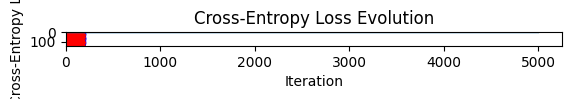

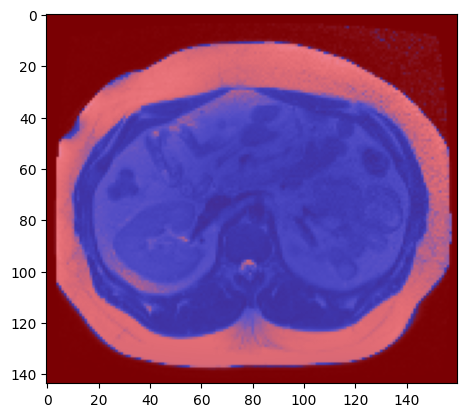

In [15]:
# Extract features and labels
d = TI.flatten()  # Input pixel intensities (flattened)
y = TS.flatten()  # Labels (flattened)
X = np.array([basis_functions(pixel, M) for pixel in d])  # Compute basis functions for all pixels

# Train the logistic regression model
indices, theta, loss_history = stochastic_gradient_descent(X, y, M, learning_rate=vm, n_iterations=numIter, batch_size=noOfSamples)

# Plot cross-entropy evolution
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Cross-Entropy Loss')
plt.title('Cross-Entropy Loss Evolution')
plt.show()

# Segment the test image
test_d = TestI.flatten()
test_X = np.array([basis_functions(pixel, M) for pixel in test_d])
test_segmentation = sigmoid(test_X @ theta).reshape(TestI.shape)

# Visualize final segmentation using provided function
plotSeg(TestI, test_segmentation)

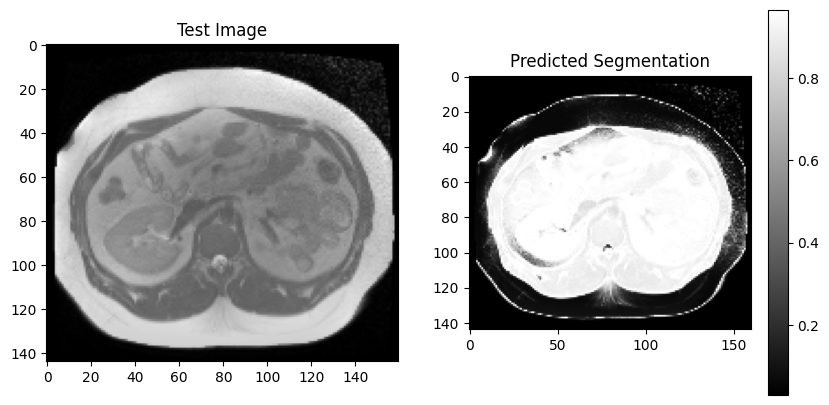

In [ ]:
# INECESARIO ES LO MISMO QUE EL ANTERIOR
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(TestI, cmap='gray')
plt.title('Test Image')

plt.subplot(1, 2, 2)
plt.imshow(test_segmentation, cmap='gray')
plt.title('Predicted Segmentation')
plt.colorbar()
plt.show()

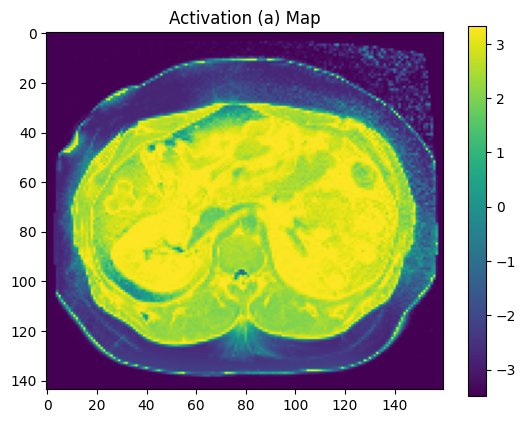

In [13]:
# Compute activations (a)
a = test_X @ theta

# Visualize the obtained classifier (activation map)
plt.imshow(a.reshape(TestI.shape), cmap='viridis')
plt.title('Activation (a) Map')
plt.colorbar()
plt.show()

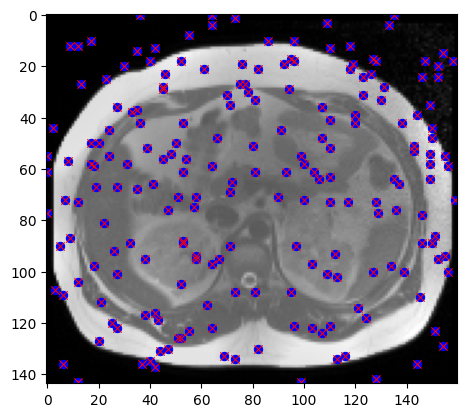

In [16]:
# At the end of stochastic_gradient_descent:
final_indices = np.column_stack(np.unravel_index(indices, TI.shape))  # Indices of last batch

# After training:
showLocationOfSamples(TI, final_indices, numIter)


## Task 2: Manipulate Intensities in Test Image

Create a new test image by replacing the intensities in the original test image using the rule
$$ d_{new} = d^{1.3}. $$

Use the classifier trained above to segment this new test image.

In your report, reflect on the result you obtain. Do the two test images look similar? What about their segmentations?

## Task 3: Adaptive Basis Functions

Now replace the fixed cosine basis functions in your model with adaptive ones of the type Eq. (4.9), and train the classifier again. The extra parameters $\beta_{m,j}$ can be initialized randomly, distributed according to a zero-mean Gaussian distribution with unit variance. For the trained model, visualize again the obtained classifier and the resulting segmentation of the original test image. This time, also include a plot of the estimated basis functions $\phi_m(d)$.



## Task 4: Use Neighbour Pixel as second Input Feature

Using the data in the file ```dataForNN_foreBorder_clip1.mat```, re-train and re-apply your classifier, but this time not just based on the intensity in the pixel being classified, but also on that of the pixel in the next row (i.e., the input x is now a vector of dimension $p = 2$). In addition to showing the classifier output on the test image, also include in your report a visualization of the learned basis functions $\phi_m(d)$ in the 2D input space, along with the learned classifier (again in the 2D input space). For the latter, please include a visualization of where the training samples $\{x_i , y_i \}$ are located (cf. the first task).

## Task 5: Use 8 Neighbours as Input Features

Using the data in the file ```dataForNN_foreBorder_clip0.mat```, re-train and re-apply the same classifier, but now using 3 × 3 patches as input, i.e., the input $x$ is now a vector of dimension $p = 9$. In your report you should include the classifier output on the test image, as well as the feature maps and the corresponding model weights $\{ \beta_{m,j} \}^{p}_{j=1}$ as visualized in Fig. 4.5(d) and Fig. 4.5(e), respectively.

## Task 6: (for the enthusiastic student)

In order to provide a more challenging task to the neural network, do task 4 again but this time using the data in the file ```dataForNN_foreBorder_clip0.mat```. Concentrate on the visualization of the learned basis functions and especially that of the classifier with respect to the training samples. Can you explain why this scenario is more challenging than the one of task 4? You can also try to add another hidden layer in the network – what do the basis functions look like now?